### Dropouts

Why does dropout work?  - Andrew Ng
https://www.youtube.com/watch?v=ARq74QuavAo 

* **Regularization**| technique to avoid overfitting 
* For every iteration, you randomly turnoff certain nodes so that we dont rely too much on certain features that causes overfitting
* If we think some layers are more suceptible to overfitting that others, we can set different dropouts for these layers
* **computer vision** - very popular. Due to less data, we tend to overfit more often

TIP: Keep plotting the loss function for every epoch to see if dropouts is helping with overfitting



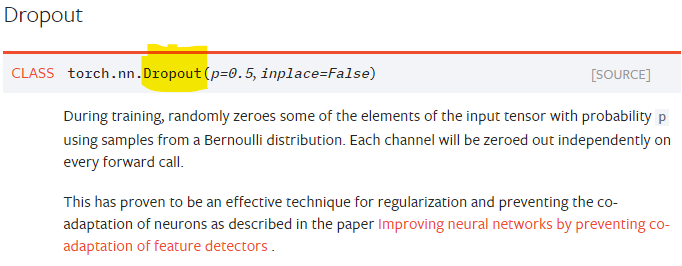

* **model.eval()** -> set drop probability = 0; during testing, validation to test entire network
* **model.train()** -> sets the model to training mode and use the specified drop probability

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)



In [4]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        #create dropuout function with drop probability = 0.2
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [6]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# epochs = 30
epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        accuracy = 0
        test_loss = 0
        
        # evaluation mode - zero drop prob
        model.eval()
        
        # Loop over test data and compute the validation accuracy
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
        # reset to training mode
        model.train()

Epoch: 1/5..  Training Loss: 0.604..  Test Loss: 0.480..  Test Accuracy: 0.826
Epoch: 2/5..  Training Loss: 0.480..  Test Loss: 0.451..  Test Accuracy: 0.834
Epoch: 3/5..  Training Loss: 0.454..  Test Loss: 0.406..  Test Accuracy: 0.856
Epoch: 4/5..  Training Loss: 0.432..  Test Loss: 0.404..  Test Accuracy: 0.862
Epoch: 5/5..  Training Loss: 0.425..  Test Loss: 0.400..  Test Accuracy: 0.855


In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

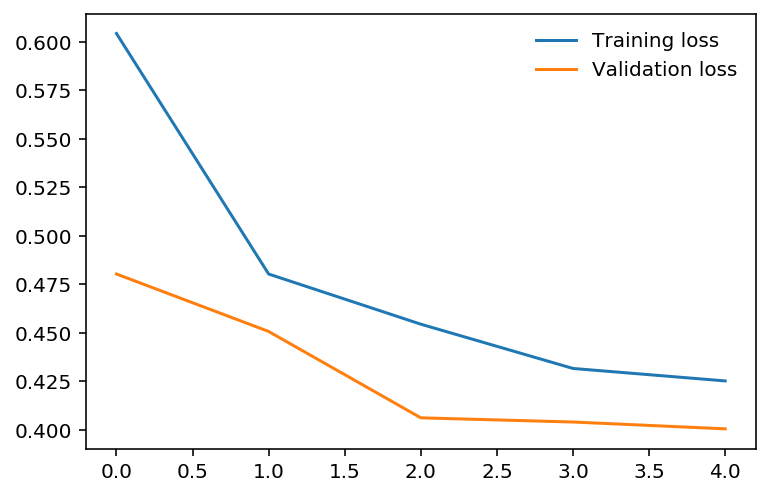

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)